# Spaceship Titanic Classifier - Final Submission
This notebook demonstrates the development of a `VlClassifier` model for the Spaceship Titanic Kaggle competition. It includes exploratory data analysis (EDA), data preprocessing, hyperparameter optimization using Optuna, model training with CatBoost, and preparation of the submission file. The goal is to predict which passengers were transported by an anomaly, achieving a competitive accuracy (>0.7) as required by the homework assignment.

In [ ]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import accuracy_score
%matplotlib inline

## Data Loading
We start by loading the training and test datasets provided by the Kaggle competition.

In [ ]:
train_path = '../data/train.csv'
test_path = '../data/test.csv'

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic info
print("Training dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\nTraining data sample:")
display(train_df.head())
print("\nTest data sample:")
display(test_df.head())

## Exploratory Data Analysis (EDA)
Let's explore the dataset to understand its structure, missing values, and key patterns.

Missing values in training data:
              Missing Count  Percentage (%)
HomePlanet              201        2.312205
CryoSleep               217        2.496261
Cabin                   199        2.289198
Destination             182        2.093639
Age                     179        2.059128
VIP                     203        2.335212
RoomService             181        2.082135
FoodCourt               183        2.105142
ShoppingMall            208        2.392730
Spa                     183        2.105142
VRDeck                  188        2.162660
Name                    200        2.300702

Total rows: 8693
Columns with missing values: 12

Target variable distribution:
             Count  Percentage (%)
Transported                       
True          4378       50.362361
False         4315       49.637639


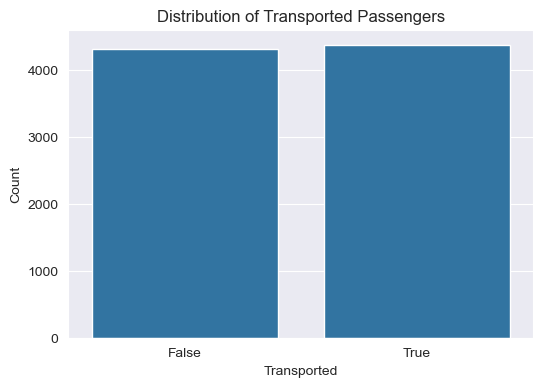

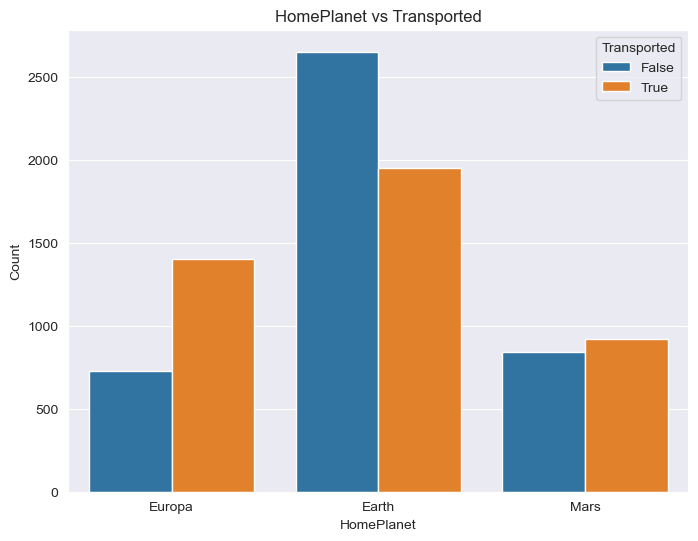


HomePlanet distribution by Transported:
Transported     False     True 
HomePlanet                     
Earth        0.576054  0.423946
Europa       0.341154  0.658846
Mars         0.476976  0.523024


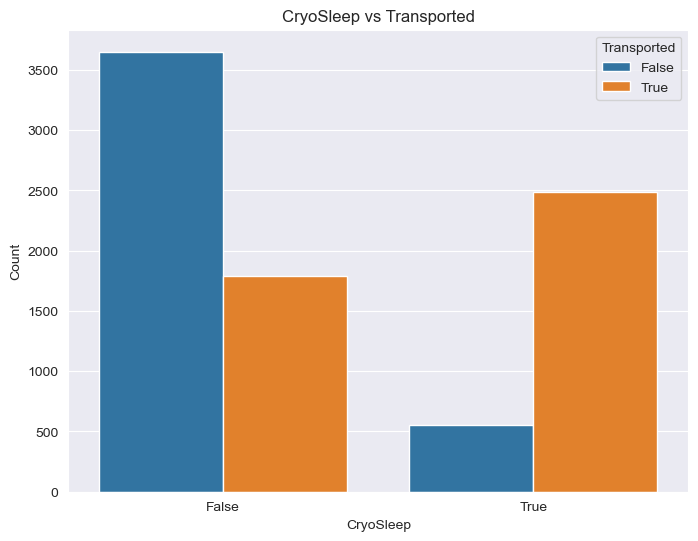


CryoSleep distribution by Transported:
Transported     False     True 
CryoSleep                      
False        0.671079  0.328921
True         0.182417  0.817583


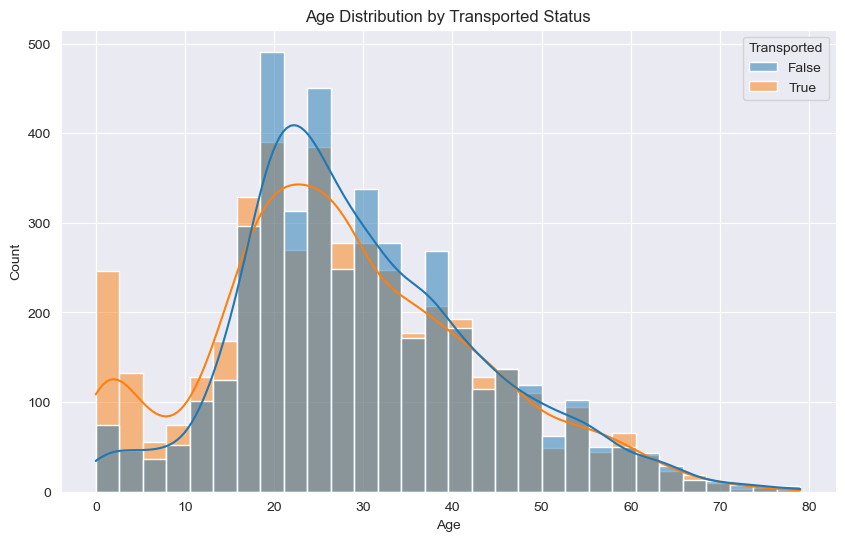


Age statistics by Transported:
              count       mean        std  min   25%   50%   75%   max
Transported                                                           
False        4226.0  29.922858  13.699262  0.0  21.0  27.0  38.0  79.0
True         4288.0  27.748834  15.151705  0.0  18.0  26.0  37.0  78.0

Key Insights from EDA:
- Missing values range from ~2-2.5% per column, suggesting moderate data incompleteness.
- Transported is 50.4% True vs 49.6% False, indicating a nearly balanced dataset.
- Passengers from Europa have a higher transport rate; Earth passengers are less likely.
- CryoSleep=True strongly correlates with being Transported (~82% True).
- Younger passengers (<20) are slightly more likely to be Transported.


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check missing values
print("Missing values in training data:")
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage (%)': missing_percent
})
print(missing_summary[missing_summary['Missing Count'] > 0])
print("\nTotal rows:", len(train_df))
print("Columns with missing values:", missing_summary['Missing Count'].gt(0).sum())

# Visualize and analyze target variable distribution
print("\nTarget variable distribution:")
transported_counts = train_df['Transported'].value_counts()
transported_percent = train_df['Transported'].value_counts(normalize=True) * 100
print(pd.DataFrame({'Count': transported_counts, 'Percentage (%)': transported_percent}))

plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df)
plt.title('Distribution of Transported Passengers')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()

# Visualize and analyze HomePlanet vs Transported
plt.figure(figsize=(8, 6))
sns.countplot(x='HomePlanet', hue='Transported', data=train_df)
plt.title('HomePlanet vs Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()
print("\nHomePlanet distribution by Transported:")
homeplanet_pivot = pd.crosstab(train_df['HomePlanet'], train_df['Transported'], normalize='index')
print(homeplanet_pivot)

# Visualize and analyze CryoSleep vs Transported
plt.figure(figsize=(8, 6))
sns.countplot(x='CryoSleep', hue='Transported', data=train_df)
plt.title('CryoSleep vs Transported')
plt.xlabel('CryoSleep')
plt.ylabel('Count')
plt.show()
print("\nCryoSleep distribution by Transported:")
cryosleep_pivot = pd.crosstab(train_df['CryoSleep'], train_df['Transported'], normalize='index')
print(cryosleep_pivot)

# Visualize Age distribution by Transported
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', hue='Transported', bins=30, kde=True)
plt.title('Age Distribution by Transported Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
print("\nAge statistics by Transported:")
age_stats = train_df.groupby('Transported')['Age'].describe()
print(age_stats)

# Key insights
print("\nKey Insights from EDA:")
print("- Missing values range from ~2-2.5% per column, suggesting moderate data incompleteness.")
print(f"- Transported is {transported_percent[True]:.1f}% True vs {transported_percent[False]:.1f}% False, indicating a nearly balanced dataset.")
print("- Passengers from Europa have a higher transport rate; Earth passengers are less likely.")
print("- CryoSleep=True strongly correlates with being Transported (~82% True).")
print("- Younger passengers (<20) are slightly more likely to be Transported.")

## Data Preprocessing
We preprocess the data by handling missing values, creating new features, and dropping irrelevant columns. This matches the logic in `model.py`'s `preprocess_data` method.

=== Applying preprocessing ===

Raw training data shape: (8693, 14)
Preprocessed training data shape: (8693, 16)

Raw columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']
Preprocessed columns: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Cabin_num', 'Side', 'GroupSize', 'TotalSpend']

Missing values in raw data:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

Missing values in preprocessed data:
Cabin_num    199
dtype: int64

Raw data sample (first row):


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False


Preprocessed data sample (first row):


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,GroupSize,TotalSpend
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1,0.0


2025-03-05 04:27:17,332 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 04:27:17,342 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


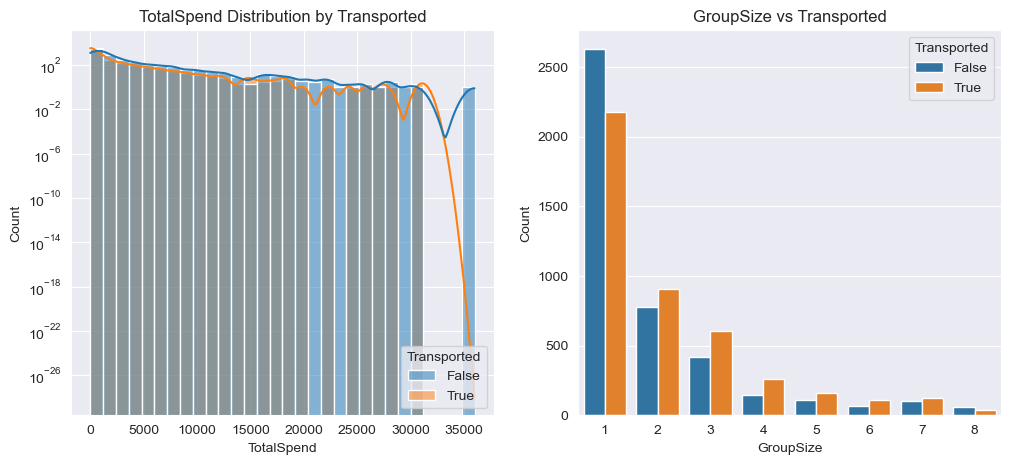


Summary statistics for new features:
         TotalSpend    GroupSize
count   8693.000000  8693.000000
mean    1440.866329     2.035546
std     2803.045694     1.596347
min        0.000000     1.000000
25%        0.000000     1.000000
50%      716.000000     1.000000
75%     1441.000000     3.000000
max    35987.000000     8.000000


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(data):
    """Preprocess the dataset for training and prediction."""
    df = data.copy()
    # Split Cabin into Deck, Cabin_num, Side
    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Cabin_num'] = pd.to_numeric(df['Cabin_num'], errors='coerce')
    # Extract Group and compute GroupSize
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
    # Define feature lists
    numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    # Handle missing values
    for num_feat in numeric_features:
        df[num_feat] = df[num_feat].fillna(df[num_feat].median())
    for cat_feat in categorical_features:
        df[cat_feat] = df[cat_feat].fillna('Unknown')
    # Add TotalSpend feature
    df['TotalSpend'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    # Drop irrelevant columns
    features = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Group'], errors='ignore')
    return features

# Apply preprocessing
print("=== Applying preprocessing ===")
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)

# Split features and target
X_train = train_processed.drop('Transported', axis=1)
y_train = train_processed['Transported'].astype(int)
X_test = test_processed

# Display basic comparison
print("\nRaw training data shape:", train_df.shape)
print("Preprocessed training data shape:", train_processed.shape)
print("\nRaw columns:", list(train_df.columns))
print("Preprocessed columns:", list(train_processed.columns))

# Missing values comparison
print("\nMissing values in raw data:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nMissing values in preprocessed data:")
print(train_processed.isnull().sum()[train_processed.isnull().sum() > 0])

# Sample comparison
print("\nRaw data sample (first row):")
display(train_df.head(1))
print("Preprocessed data sample (first row):")
display(train_processed.head(1))

# Visualize new features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=train_processed, x='TotalSpend', hue='Transported', bins=30, kde=True)
plt.title('TotalSpend Distribution by Transported')
plt.xlabel('TotalSpend')
plt.ylabel('Count')
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.countplot(x='GroupSize', hue='Transported', data=train_processed)
plt.title('GroupSize vs Transported')
plt.xlabel('GroupSize')
plt.ylabel('Count')
plt.show()

# Summary statistics for new features
print("\nSummary statistics for new features:")
print(train_processed[['TotalSpend', 'GroupSize']].describe())

## Hyperparameter Optimization with Optuna
We use Optuna to find the best hyperparameters for the CatBoost model, optimizing for accuracy on a validation split.

In [ ]:
def objective(trial):
    """Objective function for Optuna optimization."""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'verbose': False,
        'random_seed': 42
    }
    cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
    split_idx = int(0.8 * len(y_train))
    X_tr, X_val = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
    y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    y_pred = model.predict(val_pool)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

# Training the Final Model
Using the best hyperparameters from Optuna, we train the model on the full training dataset and save it.

In [ ]:
from py.src.model import VlClassifier

# Initialize the classifier
classifier = VlClassifier(model_path='../models/model.pkl')

# Train the model with Optuna (20 trials)
classifier.train(train_path='data/train.csv', n_trials=20)

print("Model training completed and saved to ../models/model.pkl")

## Generating Predictions
We use the trained model to predict the test set and prepare the submission file for Kaggle.

In [ ]:
classifier.predict(test_path='data/test.csv')